# Data Modeling 

### In this notebook, we move forward with our cleaned data and start our preprocessing and modeling 


After cleaning our data, and determining what preprocessing steps we want to integrate into our code via pipelines, we then create our baseline models. Through an iterative process we work through better performing modeling types before using a combination of high performing models. In evaluating these models, we kept in mind that simply guessing the waterpoint is functioning each time will give you a model that performs with 54% accuracy. As we began modeling, it became very clear that non-parametric models were the best fit for our data, as they better tolerate a large proportion of categorical features. As we iterated through the models, this assumption was backed up by our results. 


In [1]:
#Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import warnings

warnings.filterwarnings('ignore')

# settings to display all columns
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('data/data_cleaned.csv')

We can take a look again at our final cleaned dataset.

In [3]:
df.head()

,id,non_functional,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type
0,69572,0,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,109,True,VWC,Unknown,1999.0,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
1,8776,0,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,Serengeti,Natta,280,Unknown,Other,True,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,34310,0,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,Simanjiro,Ngorika,250,True,VWC,True,2009.0,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple
3,67743,1,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,58,True,VWC,True,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
4,19728,0,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,0,True,Unknown,True,NaN,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


## Modeling 

Because of the large number of categorical features in our dataset, we will choose model types that have high functionality with categories. 



First we start with selecting our X and y

In [4]:
X = df.drop(columns='non_functional')
y = df['non_functional']

For preprocessing purposes, we have to split our features into three different groups. One group holds our numerical data. The next deals with categorical columns that have less than 25 unique values. Finally, out last column deals with any categorical columns that have 25 or more unique values. 

In [5]:
#Lists to hold column names
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

Our deliverable to our stakeholders is the final model. With this in consideration, we decided to separate off a holdout set of values before modeling to use on our best model. After this first separation we proceed with a traditional train test split.

In [6]:
#First holdout set
X_train_big, X_holdout, y_train_big, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
#Performing train test split on the remaining data
X_train, X_test, y_train, y_test = train_test_split(X_train_big, y_train_big,
                                                    test_size = .25, random_state = 396)



In [7]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
Function takes in estimator, training data, test data, a Boolean value indicating if the estimator is a grid search, 
and the cross validation splitting strategy if the estimator is not a grid search, 
and returns the accuracy, precision, recall, f1, and the ROC-AUC scores for the model 
and a confusion matrix visualization.  

If ‘grid_search parameter is set to “True” then the function will not perform cross validation on the model. 
Based off of Lindsey Berlin’s evaluate function found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  
        Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a (Stratified)KFold,
        - CV splitter,
        - An iterable yielding (train, test) splits as arrays of indices
- grid_search – “ Boolean indicating whether a the estimator is a GridSearchCV object, 
        if set to “False” a cross validation will be performed with the number of iterations set by the “cv” parameter.  
        Default value is “False”.

Returns – nothing is returned 


    '''
    #If no grid search is being performed, go through evaluation steps as normal, including cross validation
    if grid_search == False:
        #Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
        #Printing out the mean of all of our evaluating metrics across the cross validation. 
        #Accuracy, precisionc recall, f1, and roc auc
        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    #If a grid search is being performed, do not perform a cross validate.
    else:
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train 
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
        
        print('\nGrid Search Results (you animal):\n')
        return pd.DataFrame(estimator.cv_results_)

### Preprocessing

Our preprocessing involved splitting our data into three different categories; numerical, small categorical, and large categorical. The preprossing steps for each group was as follows: 

- **Numeric Columns**
Our numerical columns were first run through an Iterative Imputer to deal with missing values by modeling each feature with missing values as a function of other features. We then use a MinMaxScaler on all numeric data to better scale our non normal distributions. 

- **Small Categorical Columns**
Our small categorical columns were run through OneHotEncoder to split each unique value into its own binary column. Columns in this category were selected due to having less than 25 unique values in their column.

- **Large Categorical Columns**
Our large categorical columns were run through a categorical encoder called Count Encoder. This was done because of their large number of unique values. The Count Encoder keeps a single column and reduces the categories in the column to their value counts. 

- **All Categorical Columns**
Alternatively we explored the use of [catboost encoding](https://contrib.scikit-learn.org/category_encoders/catboost.html) for all of our categorical encoders. 


Our first step in our modeling process is to set up some pipelines to deal with our data. 

In [8]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories


num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

#We created category that would use catboost for all categorical features for further evaluation.

all_cat_col_pipe = Pipeline(steps = [
    ('catboost', CatBoostEncoder(random_state=396))
])

Our next step is to create preprocessors that will easily streamline the handling of our data for use in future pipelines. 

In [9]:
#Preprocessor1 makes a distinction between our small and large categorical columns 
preprocessor1 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])
#Preprocessor2 takes in all categorical features no matter the size
# and handles them using CatBoostEncoder
preprocessor2 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('cat', all_cat_col_pipe, [*sm_cat_cols, *lg_cat_cols]),
])

## Baseline Evaluation

To get an initial understanding of what a modelless prediction looks like, we used DummyClassifier. Our most frequent value in our predictor column is `functioning`. If we were to predict functioning on our test dataset, we would be right around 54% of the time. Any model we create moving forward should outperform this baseline.

Results of Cross-Validation:

Average accuracy: 0.5431494883953081        +/- 4.9912652857475586e-05
Average precision: 0.0        +/- 0.0
**Average recall: 0.0        +/- 0.0
Average f1 score: 0.0        +/- 0.0
Average roc_auc: 0.5        +/- 0.0

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5431494883953082
Train precision: 0.0
**Train recall: 0.0
Train f1 score: 0.0
Train roc_auc: 0.5

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5414389458710789
Test precision: 0.0
**Test recall: 0.0
Test f1 score: 0.0
Test roc_auc: 0.5


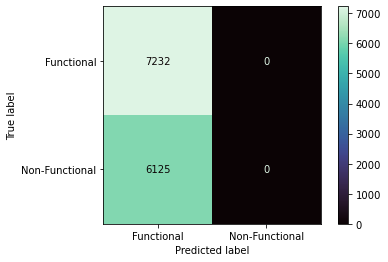

In [10]:
#Pipeline for preprocessing and modeling
baseline_evaluation = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

#Putting our model through our evaluate function
evaluate(baseline_evaluation, X_train, X_test, y_train, y_test, cv=5)

**Results**

- After evaluating our baseline model, we see that it has an accuracy of 54% on the testing data. All other evaluating metric scores are 0 and our roc_auc shows a value of .5, confirming this is a poor model.

# Parametric vs. Non-parametric Modeling

As we move forward in our modeling, we want to make an initial evaluation of parametric and non-parametric models against one another to provide direction for future modeling decisions. We will compare a logistic regresison model to a decision tree model. We expect the non-parametric decision tree to perform better because it is well equiped to handle categorical data. 

## Logistic Regression Model



Results of Cross-Validation:

Average accuracy: 0.7174943848265535        +/- 0.015325501044653429
Average precision: 0.7358609891647862        +/- 0.01680253180110356
**Average recall: 0.5948851690908241        +/- 0.025143502775855472
Average f1 score: 0.6578082563573079        +/- 0.02160212307885155
Average roc_auc: 0.7809795185127753        +/- 0.015509342705686022

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5673072123783379
Train precision: 0.5509473684210526
**Train recall: 0.28591718562220036
Train f1 score: 0.3764655110407825
Train roc_auc: 0.544952711539275

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5666691622370292
Test precision: 0.5527386541471049
**Test recall: 0.2883265306122449
Test f1 score: 0.3789699570815451
Test roc_auc: 0.5453662520317862


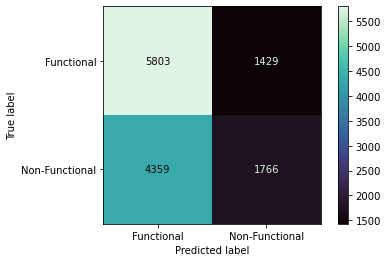

In [11]:
#Pipeline for preprocessing and modeling
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', LogisticRegression(random_state=396))
])

#Putting our logistic regression model through our evaluate function
evaluate(logreg, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Our baseline logistic regression shows only a slight improvement over our dummy classifier model in every single metric used to evaluate.
- All metrics are quite low -- in particular our recall score is unacceptably low at 29%. Given the large number of categorical features, this is all to be expected.

## Decision Tree

Results of Cross-Validation:

Average accuracy: 0.750262041427502        +/- 0.006833022123599001
Average precision: 0.7218269684965126        +/- 0.009263669744064939
**Average recall: 0.7377904673987746        +/- 0.004731566221769646
Average f1 score: 0.7297018074987742        +/- 0.006378236817575044
Average roc_auc: 0.749271185122341        +/- 0.006563798539038056

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7573556936437823
Test precision: 0.7296909843899331
**Test recall: 0.7479183673469387
Test f1 score: 0.7386922518745465
Test roc_auc: 0.7566334093371861


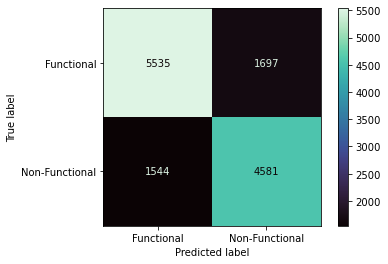

In [12]:
#Pipeline for preprocessing and modeling 
dt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

#Putting our decision tree baseline through our evaluate function
evaluate(dt, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Our decision tree model performed significantly better than our baseline model and logistic regression in every metric of evaluation. It is worth noting that this model is overfit on the training data but it stills performs much much better than previous models on the testing data.

# Further Non-parametric Modeling 

Because our initial Decision Tree performs better than Logistic Regression across all metrics, we will continue moving forward with non-parametric modeling. 

## Random Forest

We found that a single decision tree gave us a significant improvement in results. To move forward, we will start working with Random Forest which uses multiple decision trees in its modeling. We will also compare our different preprocessing options to see if there are any differences in results.

Results of Cross-Validation:

Average accuracy: 0.8163214374844022        +/- 0.002409287424237006
Average precision: 0.826344324310344        +/- 0.005677841054201111
**Average recall: 0.7571287745079245        +/- 0.006276391866409888
Average f1 score: 0.790188166446984        +/- 0.002844295514499265
Average roc_auc: 0.894404629088819        +/- 0.0024281142451172293

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8209927378902449
Test precision: 0.8333928571428572
**Test recall: 0.7619591836734694
Test f1 score: 0.7960767590618337
Test roc_auc: 0.8164746139606285


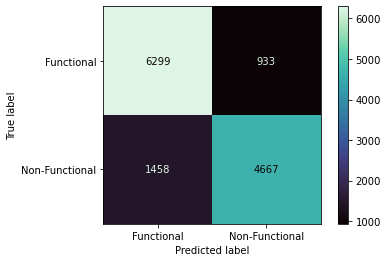

In [13]:
#Pipeline for preprocessing and modeling 
rf1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396))
])
#Putting our random forest through our evaluate function
evaluate(rf1, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Random Forest is performing better than a single decision tree on all metrics. 
- Like the decision tree, this model is also overfit on the training data but performs well on testing data.
- **Note:** Not presented in this notebook is further hyperparameter tuning to try to improve metric scores. Ultimately the default hyperparameters performed best.

Running the model through our other preprocessor to evaluate differences with the type of categorical preprocssing. Let's see if CatBoost does any better.

Results of Cross-Validation:

Average accuracy: 0.8017718991764411        +/- 0.003928224081846972
Average precision: 0.8253557646774837        +/- 0.006802787290684527
**Average recall: 0.7181249180439877        +/- 0.007776437575354086
Average f1 score: 0.7679744663185317        +/- 0.004911935790124266
Average roc_auc: 0.8786947891492594        +/- 0.0025936439275698344

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.865710007486898
Train precision: 0.8979126901052891
**Train recall: 0.7966240576860046
Train f1 score: 0.8442411786841116
Train roc_auc: 0.8602216042886924

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8046717077187991
Test precision: 0.8297074268567142
**Test recall: 0.7222857142857143
Test f1 score: 0.7722789560967094
Test roc_auc: 0.7983663084702908


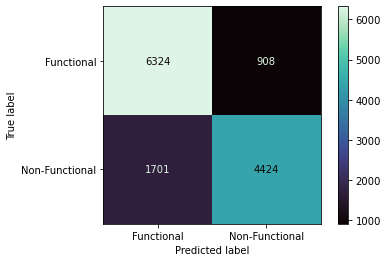

In [14]:
#Pipeline for preprocessing and modeling
rf2 = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('classifier', RandomForestClassifier(random_state=396))
])
#Putting our random forest with preprocessor2 through our evaluate function
evaluate(rf2, X_train, X_test, y_train, y_test, cv=5)

**Results**
- The catboost encoding did not lead to an increase in model performance in any metric despite reducing overfitting.

## Adaboost

We decided to explore other non-parametric ensemble methods, beyond random forest. Adaboost is included here because it contributes to our final model, despite its lower scoring in comparison to random forest. 

A gradient boost classifier was also examined but is not included here because it did not do as well as other models. Look further in personal notebooks if you're curious.

Results of Cross-Validation:

Average accuracy: 0.7467681557274769        +/- 0.003431472196308603
Average precision: 0.7844656567033667        +/- 0.0024194159171063044
**Average recall: 0.6146060643943401        +/- 0.012452073374971798
Average f1 score: 0.6891391631449573        +/- 0.007173486992449794
Average roc_auc: 0.8244678458973114        +/- 0.0032480373855838635

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7478911904167707
Train precision: 0.784623924507355
**Train recall: 0.6177209658035617
Train f1 score: 0.6912402958616052
Train roc_auc: 0.737550062023266

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7475481021187392
Test precision: 0.7864724245577523
**Test recall: 0.6169795918367347
Test f1 score: 0.691491308325709
Test roc_auc: 0.737555061405093


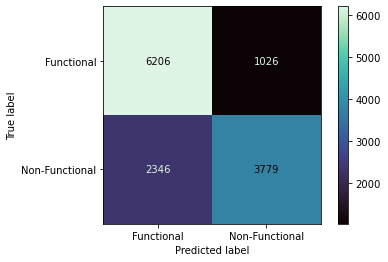

In [15]:
#Pipeline for preprocessing and modeling
adbst = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier(random_state=396))
])

#Putting adaboost through our evaluate function
evaluate(adbst, X_train, X_test, y_train, y_test, cv=5)

**Results**
- Due to the significant drop in recall score, adaboost on it's own was discarded as a standalone potential final model.

### Other Considerations
- We performed a gridsearch on a few of our models in notebooks found in personal folders. The results were subpar and not fit for inclusion in our final model.
- Other Model types were examined, please reference personal notebooks.

## Voting Classifier - Final Model

We felt that the logic behind AdaBoost was sound, despite its low scores, so we wanted to see if it could help improve our top performer, RandomForest. We used a VotingClassifier and weighed it more heavily in favor of RandomForest.

In [16]:
w_avg = VotingClassifier(estimators=[
    ('ada', adbst),
    ('rndfor', rf1)],
    weights=[0.25, 0.75], voting = 'soft')

Results of Cross-Validation:

Average accuracy: 0.816246568505116        +/- 0.0025942578477496534
Average precision: 0.8250221415085994        +/- 0.005128887445870006
**Average recall: 0.7587675814760242        +/- 0.006842820600317659
Average f1 score: 0.7904750774468964        +/- 0.0033039917197465215
Average roc_auc: 0.8947367035469279        +/- 0.0024034085678559212

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8212173392228794
Test precision: 0.8322959274408679
**Test recall: 0.7640816326530612
Test f1 score: 0.7967313585291114
Test roc_auc: 0.8168444667690085


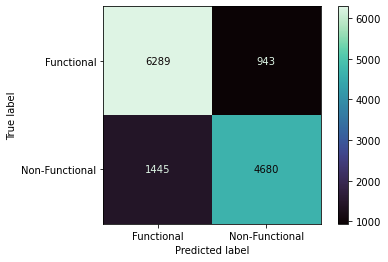

In [17]:
evaluate(w_avg, X_train, X_test, y_train, y_test, cv=5)

**Results**
- This composite classifier did indeed perform marginally better than the lone RandomForest on the testing scores.

### Testing on Holdout Set
Now that we have our top performer, let's see how it does on the holdout set. This simulates the accuracy of the model on unseen data.

Results of Cross-Validation:

Average accuracy: 0.8210455096697835        +/- 0.0037431677412490313
Average precision: 0.8299271714429152        +/- 0.0026153039664668603
**Average recall: 0.7655433174516902        +/- 0.009866371532775137
Average f1 score: 0.7963999654838649        +/- 0.005407150440460352
Average roc_auc: 0.8989890413424089        +/- 0.002955958156236045

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.9999812828719561
Train precision: 1.0
**Train recall: 0.9999590683967091
Train f1 score: 0.9999795337794969
Train roc_auc: 0.9999795341983546

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8271854471955533
Test precision: 0.8342674139311449
**Test recall: 0.7729970326409495
Test f1 score: 0.8024643819792068
Test roc_auc: 0.8226293401402835


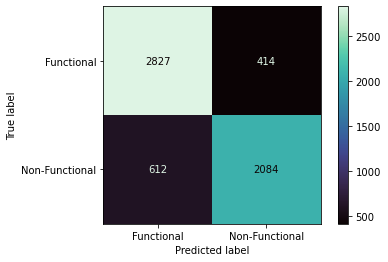

In [18]:
evaluate(w_avg, X_train_big, X_holdout, y_train_big, y_holdout)

## Final Evaluation and Conclusion

As we can see, the composite VotingClassifier model performs very well with the holdout data! The scores are all the highest of any model, and importantly the recall is the highest. 

The problem we are trying to address is to create a model that can predict the function state of a water pump based on the data collected about it. In particular, we care about whether a pump is correctly identified as non-functional so we can reduce the number of people suffering without water. Because of this, recall was deemed the most important metric, as it gives the correct guess frequency among the pumps that are indeed non-functional.

As our final composite classifier performed so well on the holdout data, we are highly confident that our model is generalizable to unseen data and would be an effective tool for the government of Tanzania. However, it is worth noting that this model can only do so much with the data it received. If the Tanzanian government wished to improve their predictive capabilities, we would recommend they revisit their data collection methods, as more robust descriptors and information would lead to a more robust predictive model.